#### About this repository:

The notebooks in this repository are meant to serve as comprehensive building blocks for establishing an algorithmic trading system. 
 
A number of sample trading strategies are included, along with methodologies to determine their robustness. Walk-Forward Analysis is one such well known technique, while Combinatorial Purged Cross Validation is a newer and more  rigorous methodology. Another useful and important concept is Meta Labelling, which predicts the probability of individual winning trades. All three techniques are utilized here to help improve the rigor of the systematic trading research process. 

Even though the methodologies presented in these notebooks can always be fine-tuned further, they are sophisticated enough to provide rigorous backtesting of any algorithmic trading strategy. After looking through this repository, one should gain an understanding of how algorithmic trading startegies are programmed and backtested. Identifying such strategies can simply be a matter of adapting algorithms found in research journals or trading websites; the aim of these notebooks is to determine a strategy's profitability and robustness. The final step of live trading a strategy should be merely trivial rewriting of a few lines of code in the Zipline version of the strategy. 


*Hoa Tuan Nguyen:* http://linkedin.com/in/hoatuannguyen/

## Mixed Bollinger Bands Strategy:

This notebook backtests the Mixed Bollinger Bands strategy in Zipline. 

This strategy combines the Mean Reversion with Bollinger Bands strategy and the Momentum with Bollinger Bands strategy in a manner that seeks to get the best of both worlds. Please refer to the corresponding notebooks for more information about either of these strategies. 

There are a couple of minor changes but the spirit is largely the collaboration of the other two strategies. When the fast moving average (fma) bursts through the upper or lower band, a trending trade is put on. When the fma comes back within either band, the trending trade is liquidated and a sideways trade is put on instead. 

Otherwise, when either type of trade is put on, there is a limit price.

In [1]:
%load_ext zipline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from collections import OrderedDict
from datetime import datetime, timedelta
import pytz

import zipline
from zipline.api import *
from zipline.utils.always_open import AlwaysOpenCalendar

import pyfolio as pf

In [3]:
data = OrderedDict()
data['BTC'] = pd.read_csv("data/btc_2019_aug6_2020.csv",index_col=0,parse_dates=True)

# Zipline only allows trading of whole number of any particular security.
# However, BTC is traded on exchanges in tiny fractions of a single Bitcoin. 
# To allow for realistic backtesting with Zipline, we rescaled the price and volume of BTC
muliplier = 100
data['BTC'].loc[:,'open':'close'] /= muliplier
data['BTC'].volume *= muliplier

panel = pd.Panel(data)
panel.minor_axis = ["open","high","low","close","volume"]
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)

In [14]:
def initialize(context):
    set_benchmark(symbol('BTC'))
    context.security = symbol('BTC')

    # flags to help manage trading
    context.lower_breached = False
    context.upper_breached = False
    context.can_close = False
    context.sideways_on = False
    context.trending_on = False

    # to help debug
    context.times_breaches = 0
    context.take_profit = 0
    context.stopped_out = 0
    context.orders_cancelled = 0
    context.pos_ret = 0
    context.neg_ret = 0


def handle_data(context, data):
    price_history = data.history(
        context.security,
        fields='close',
        bar_count=5400,
        frequency='1m'
    )

    current_price = price_history[-1]
    
    fast_mva = price_history[-260:].mean()
    slow_mva = price_history.mean()
    std_price = price_history.std()
    upper = slow_mva + 1.8 * std_price
    lower = slow_mva - 1.8 * std_price
       
    pos_amount = context.portfolio.positions[context.security].amount
    btc_orders = get_open_orders(context.security)
    open_orders = False if len(btc_orders) == 0 else btc_orders[0].status == 0
    filled_price = context.portfolio.positions[context.security].cost_basis

    # put on trending trades
    if fast_mva >= upper and not context.upper_breached and not open_orders and not pos_amount:
        order_target_percent(context.security, 1, limit_price=fast_mva * 1.01)
        context.upper_breached = True
        context.trending_on = True
        context.times_breaches += 1
    elif fast_mva <= lower and not context.lower_breached and not open_orders and not pos_amount:
        order_target_percent(context.security, -1, limit_price=fast_mva * .99)
        context.lower_breached = True
        context.trending_on = True
        context.times_breaches += 1

    # put on sideways trades
    elif not open_orders and not pos_amount and context.upper_breached and fast_mva <= upper:
        order_target_percent(context.security, -1, limit_price=fast_mva * .995)
        context.upper_breached = False
        context.sideways_on = True
    elif not open_orders and not pos_amount and context.lower_breached and fast_mva >= lower:
        order_target_percent(context.security, 1, limit_price=fast_mva * 1.005)
        context.lower_breached = False
        context.sideways_on = True

    # cancel orders that take too long to execute
    elif open_orders and btc_orders[0].status == 0 and get_datetime() - btc_orders[0].created >= timedelta(minutes=30):
        cancel_order(btc_orders[0])
        context.orders_cancelled += 1
        
    # set breached flags:
    elif fast_mva >= upper and not context.upper_breached:
        context.upper_breached = True
        context.times_breaches += 1
    elif fast_mva <= lower and not context.lower_breached:
        context.lower_breached = True
        context.times_breaches += 1

    # take profits or stop loss on short trending trade
    elif context.trending_on and not open_orders and pos_amount < 0:
        prct_changed = (filled_price - current_price) / filled_price
        if not context.can_close and prct_changed >= .015:
            context.can_close = True
        if fast_mva >= lower and context.can_close:
            #order_target_percent(context.security, 0.5)  # immediately switch to long sideways
            #context.sideways_on = True
            order_target_percent(context.security, 0)    # this allows putting on sideways trade w/ a limit            
            context.lower_breached = False
            context.can_close = False
            context.trending_on = False
            if prct_changed > 0:
                context.pos_ret += 1
            else:
                context.neg_ret += 1
        else:
            if prct_changed >= .07:
                order_target_percent(context.security, 0)
                context.take_profit += 1
                context.pos_ret += 1
                context.can_close = False
                context.trending_on = False
            elif prct_changed <= -.02:
                order_target_percent(context.security, 0)
                context.stopped_out += 1
                context.neg_ret += 1
                context.can_close = False
                context.trending_on = False

    # take profits or stop loss on long trending trade
    elif context.trending_on and not open_orders and pos_amount > 0:
        prct_changed = (current_price - filled_price) / filled_price
        if not context.can_close and prct_changed >= .015:
            context.can_close = True
        if fast_mva <= upper and context.can_close:
            #order_target_percent(context.security, -0.5)  # immediately switch to short sideways
            #context.sideways_on = True
            order_target_percent(context.security, 0)   # this allows putting on sideways trade w/ a limit            
            context.upper_breached = False
            context.can_close = False
            context.trending_on = False
            if prct_changed > 0:
                context.pos_ret += 1
            else:
                context.neg_ret += 1
        else:
            if prct_changed >= .07:
                order_target_percent(context.security, 0)
                context.take_profit += 1
                context.pos_ret += 1
                context.can_close = False
                context.trending_on = False
            elif prct_changed <= -.02:
                order_target_percent(context.security, 0)
                context.stopped_out += 1
                context.neg_ret += 1
                context.can_close = False
                context.trending_on = False

    # take off short sideways trade
    elif context.sideways_on and not open_orders and pos_amount < 0:
        prct_changed = (filled_price - current_price) / filled_price
        if fast_mva <= slow_mva:
            order_target_percent(context.security, 0)
            context.sideways_on = False
            if prct_changed > 0:
                context.pos_ret += 1
            else:
                context.neg_ret += 1
        elif prct_changed >= .04:
            order_target_percent(context.security, 0)
            context.sideways_on = False
            context.take_profit += 1
            context.pos_ret += 1
        elif prct_changed <= -.015:
            order_target_percent(context.security, 0)
            context.sideways_on = False
            context.stopped_out += 1
            context.neg_ret += 1

    # take off long sideways trade
    elif context.sideways_on and not open_orders and pos_amount > 0:
        prct_changed = (current_price - filled_price) / filled_price
        if fast_mva >= slow_mva:
            order_target_percent(context.security, 0)
            context.sideways_on = False
            if prct_changed > 0:
                context.pos_ret += 1
            else:
                context.neg_ret += 1
        elif prct_changed >= .04:
            order_target_percent(context.security, 0)
            context.sideways_on = False
            context.take_profit += 1
            context.pos_ret += 1
        elif prct_changed <= -.015:
            order_target_percent(context.security, 0)
            context.sideways_on = False
            context.stopped_out += 1
            context.neg_ret += 1

    # reset breached flags
    elif fast_mva > lower and fast_mva < upper and context.upper_breached or context.lower_breached:
        context.lower_breached = False
        context.upper_breached = False

    record(times_breached=context.times_breaches, canceled=context.orders_cancelled,
           take_profits=context.take_profit, stopped_out=context.stopped_out,
           pos_ret = context.pos_ret, neg_ret = context.neg_ret)


In [15]:
perf = zipline.run_algorithm(start=datetime(2020, 3, 1, 0, 0, 0, 0, pytz.utc),
                      end=datetime(2020, 6, 1, 0, 0, 0, 0, pytz.utc),
                      initialize=initialize,
                      handle_data=handle_data,
                      trading_calendar=AlwaysOpenCalendar(),
                      capital_base=20000,
                      data_frequency ='minute',
                      data=panel)

/anaconda3/envs/env_zipline/lib/python3.5/site-packages/empyrical/stats.py:790: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


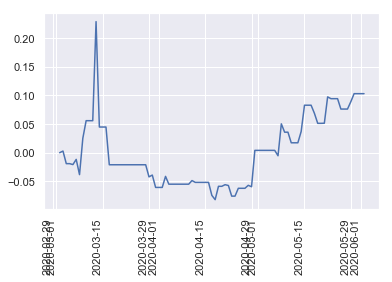

In [16]:
# sideways with slow=5400, fast=260, mult=1.8

perf.algorithm_period_return.plot()
plt.xticks(rotation='vertical')
plt.show()

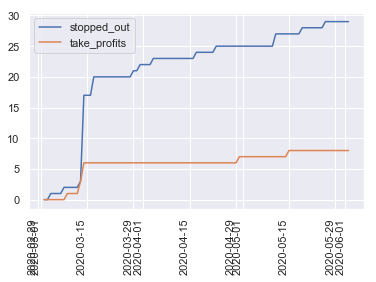

In [17]:
perf.stopped_out.plot()
perf.take_profits.plot()
plt.legend()
plt.xticks(rotation='vertical')
plt.show()

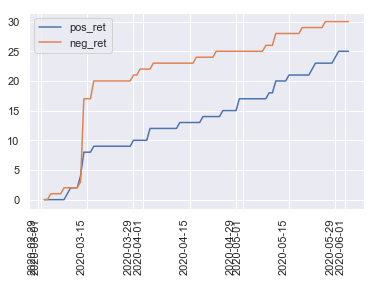

In [18]:
perf.pos_ret.plot()
perf.neg_ret.plot()
plt.legend()
plt.xticks(rotation='vertical')
plt.show()

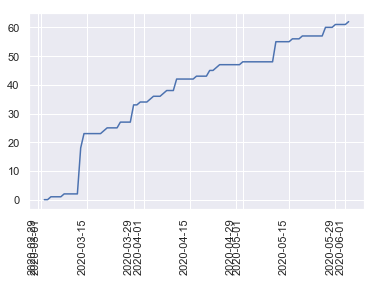

In [19]:
perf.canceled.plot()
plt.xticks(rotation='vertical')
plt.show()